# Importing necessary libraries

In [54]:
import os
import multiprocessing
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
style.use('fivethirtyeight')

# Directory paths


In [55]:
data_dir = "C:\\Users\\cherm\\PycharmProjects\\Traffic-Sign-Recognition-main\\dataset"
train_path = os.path.join(data_dir, 'Train')
test_path = os.path.join(data_dir, 'Test')

# Constants for image resizing

In [56]:
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

# Number of categories


In [57]:
no_categories = len(os.listdir(train_path))
print(f"Available Numbers of Categories in dataset : {no_categories}")

Available Numbers of Categories in dataset : 43


# Mapping classes to their labels

In [58]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

# Visualizing Class Distribution


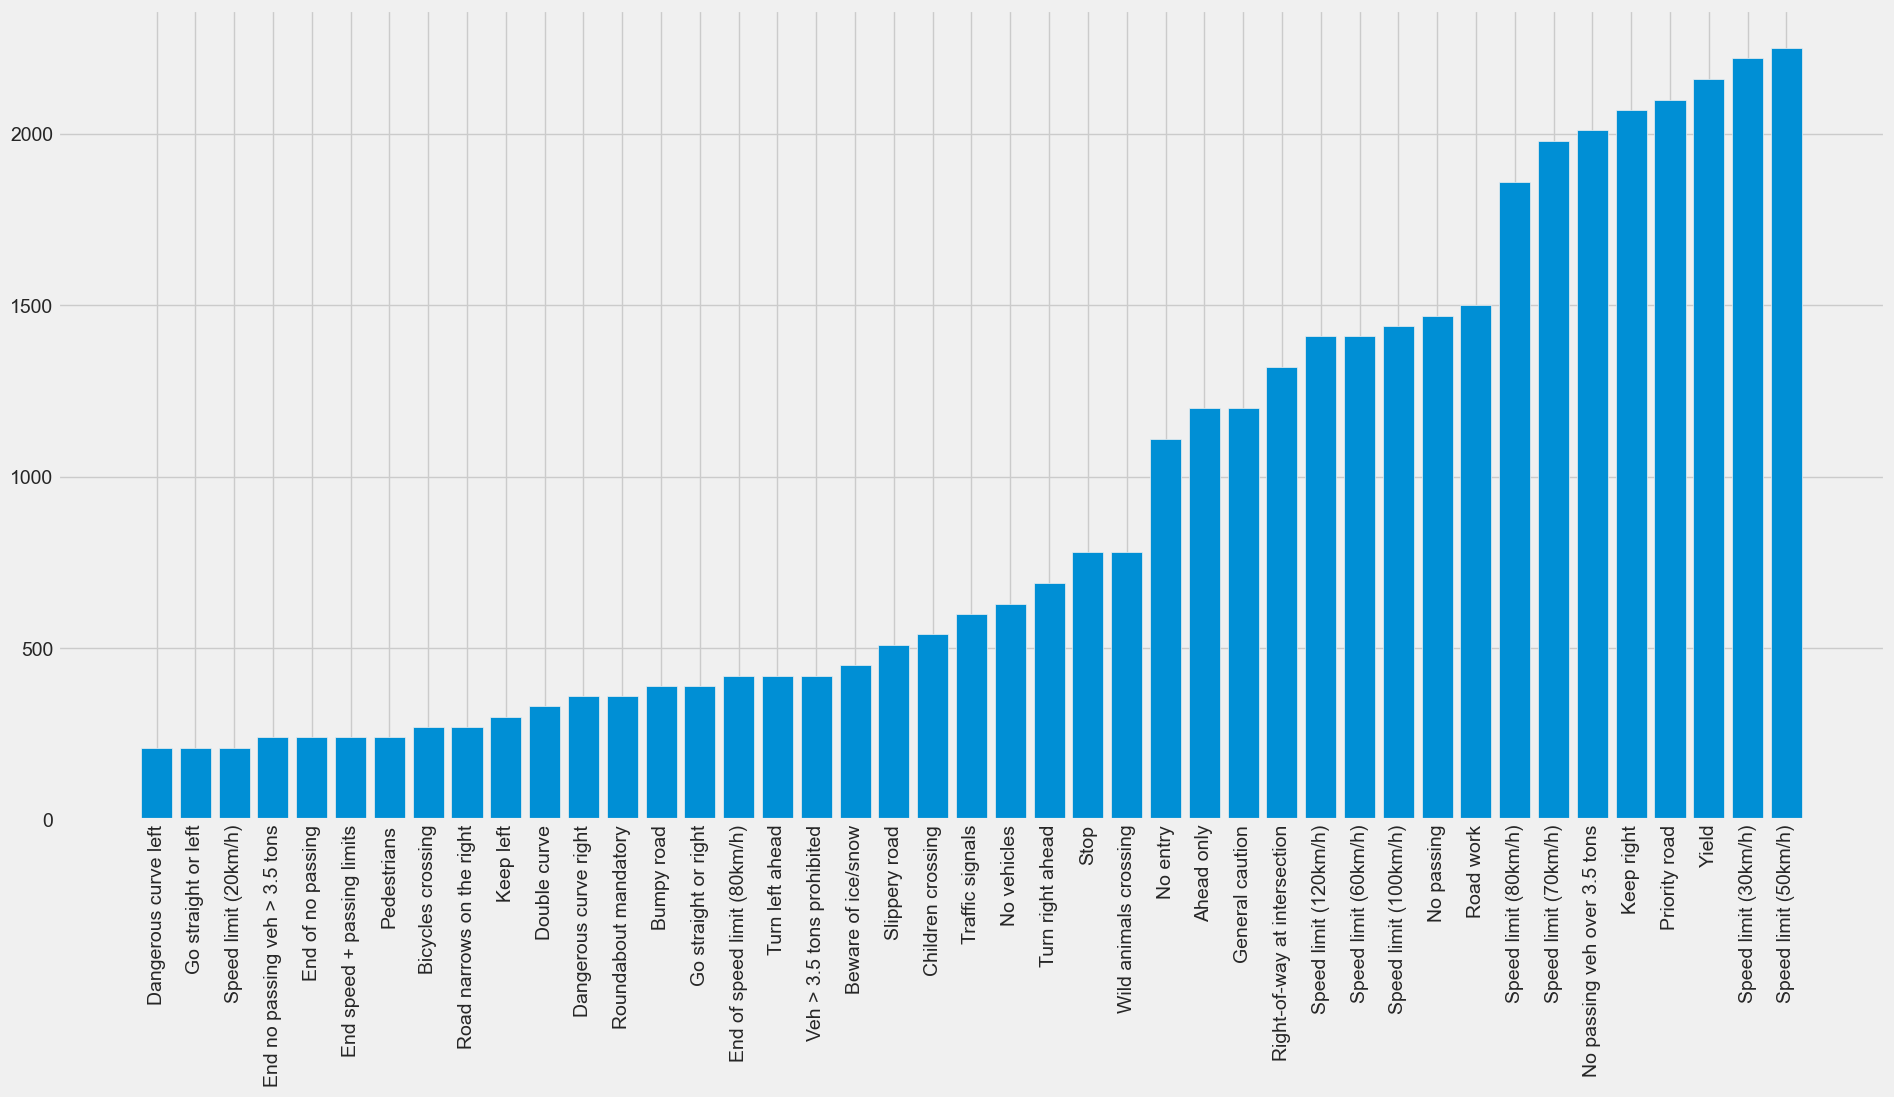

In [59]:
# Listing folders in the training directory
folders = os.listdir(train_path)

# Lists to store number of images and class names
train_number = []
class_num = []

# Counting the number of images in each class
for folder in folders:
    train_files = os.listdir(os.path.join(train_path, folder))
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset based on the number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Collecting the Training Data by resizing it to the specified dimensions.

In [60]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

def process_image(image_path, category_index, IMG_HEIGHT, IMG_WIDTH):
    try:
        image = Image.open(image_path).convert("RGB")
        resized_image = image.resize((IMG_WIDTH, IMG_HEIGHT))
        return np.array(resized_image), category_index
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def load_images(data_dir, IMG_HEIGHT, IMG_WIDTH):
    image_data = []
    image_labels = []
    for category_index in tqdm(range(no_categories), desc="Loading categories"):
        category_path = os.path.join(data_dir, 'Train', str(category_index))
        image_files = os.listdir(category_path)

        for image_file in image_files:
            result = process_image(os.path.join(category_path, image_file), category_index, IMG_HEIGHT, IMG_WIDTH)
            if result:
                image_data.append(result[0])
                image_labels.append(result[1])

    return np.array(image_data), np.array(image_labels)

# Виклик
image_data, image_labels = load_images(data_dir, IMG_HEIGHT, IMG_WIDTH)
print("Image data shape:", image_data.shape)
print("Image labels shape:", image_labels.shape)

Loading categories: 100%|██████████| 43/43 [00:07<00:00,  5.64it/s]

Image data shape: (39209, 30, 30, 3)
Image labels shape: (39209,)


# Shuffling the training data

In [61]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# Splitting the data into train and validation set

In [62]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

# Dividing by 255 is a simple way to normalize pixel values in the range [0, 1]
X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


# One hot encoding the labels

In [63]:
import keras

y_train = keras.utils.to_categorical(y_train, no_categories)
y_val = keras.utils.to_categorical(y_val, no_categories)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


# Define model architecture

In [64]:
# model = keras.models.Sequential([
#     keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
#     keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
#     keras.layers.MaxPool2D(pool_size=(2, 2)),
#     keras.layers.BatchNormalization(axis=-1),
#
#     keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#     keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
#     keras.layers.MaxPool2D(pool_size=(2, 2)),
#     keras.layers.BatchNormalization(axis=-1),
#
#     keras.layers.Flatten(),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(rate=0.5),
#
#     keras.layers.Dense(43, activation='softmax')
# ])

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

C:\Users\cherm\PycharmProjects\Traffic-Sign-Recognition-main\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the model

In [65]:
from keras.src.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Data Augmentation


In [85]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

image_augmentor = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [93]:


history = model.fit(
    image_augmentor.flow(X_train, y_train, batch_size=64),
    epochs=70,
    validation_data=(X_val, y_val),
)

Epoch 1/70
  4/429 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 1.0000 - loss: 8.8409e-04 

C:\Users\cherm\PycharmProjects\Traffic-Sign-Recognition-main\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 2/70
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0025
Epoch 3/70
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9994 - val_loss: 0.0025
Epoch 4/70
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 5/70
429/429 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0025
Epoch 6/70
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 0.9993 - val_loss: 0.0024
Epoch 7/70
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 8/70
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.999

# Save model and its weights, then load them

In [103]:
# Save the entire model
model.save("C:\\Users\\cherm\\PycharmProjects\\Traffic-Sign-Recognition-main\\model\\model.h5")



In [104]:
# Load the entire model
loaded_model = keras.models.load_model("C:\\Users\\cherm\\PycharmProjects\\Traffic-Sign-Recognition-main\\model\\model.h5")



In [105]:
loaded_model

<Sequential name=sequential_3, built=True>

## Evaluating the model

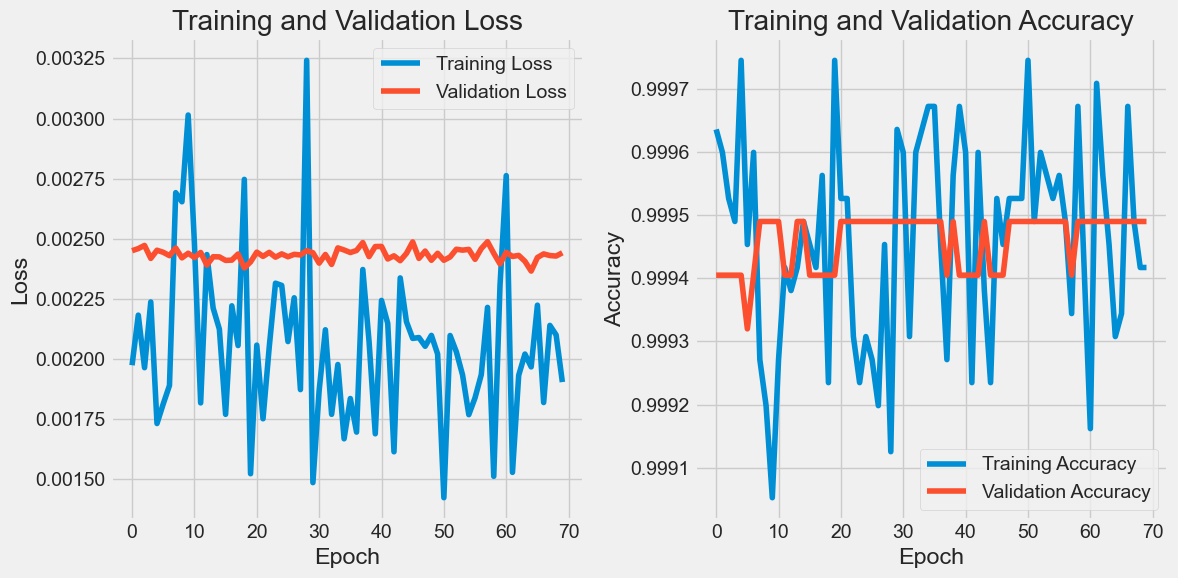

In [106]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Loading the test data and running the predictions

In [107]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]
# Resizing the images
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test/255

# Get class probabilities for each image
pred_probs = loaded_model.predict(X_test)

# Convert probabilities to class labels
pred_classes = np.argmax(pred_probs, axis=1)


# Calculate accuracy
accuracy = accuracy_score(labels, pred_classes)
print(f"The accuracy on test data: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
The accuracy on test data: 70.10%


## Visualizing the Confusion Matrix

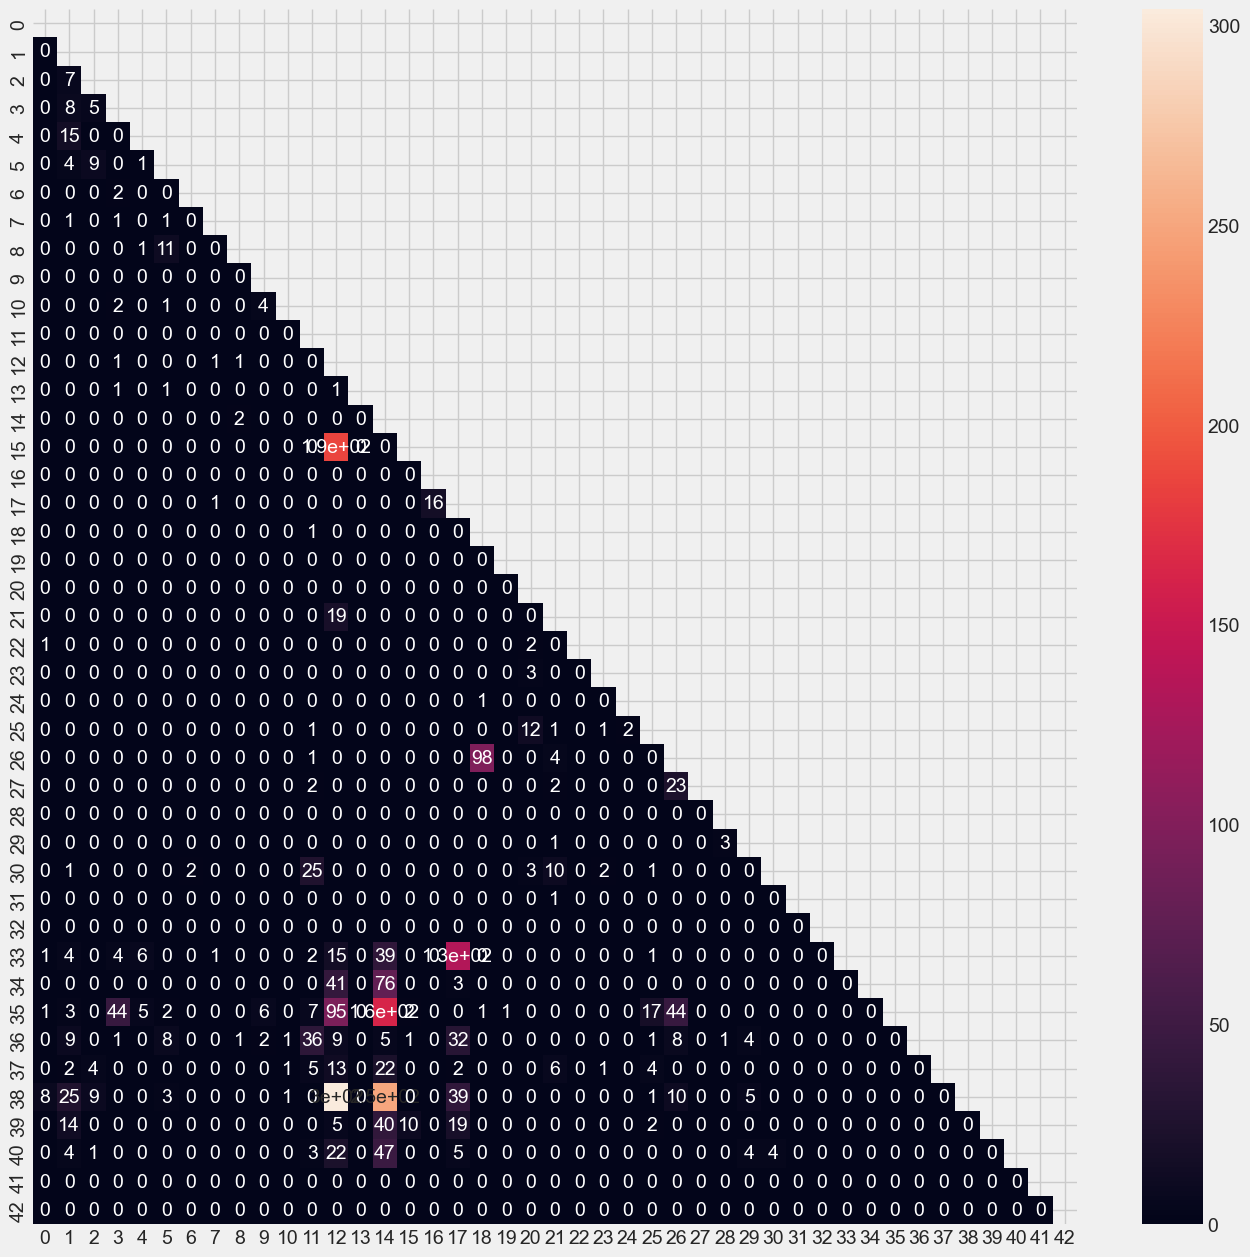

In [82]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, pred_classes)

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(conf_matrix, dtype=bool))

# Create DataFrame for the confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot the heatmap with the upper triangle only
plt.figure(figsize=(15, 15))
sns.heatmap(df_cm, annot=True, mask=mask)
plt.show()

## Classification report

In [74]:
report = classification_report(labels, pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.97      0.90        60
           1       0.88      0.97      0.92       720
           2       0.96      0.97      0.97       750
           3       0.87      0.86      0.87       450
           4       0.98      0.96      0.97       660
           5       0.93      0.87      0.90       630
           6       0.99      0.99      0.99       150
           7       0.98      0.95      0.97       450
           8       0.98      0.93      0.95       450
           9       0.97      0.93      0.95       480
          10       0.99      0.89      0.94       660
          11       0.83      0.99      0.91       420
          12       0.06      0.07      0.06       690
          13       1.00      1.00      1.00       720
          14       0.11      0.30      0.16       270
          15       0.63      0.11      0.19       210
          16       0.90      1.00      0.95       150
          17       0.28    

## Visualize Predictions on Test Data

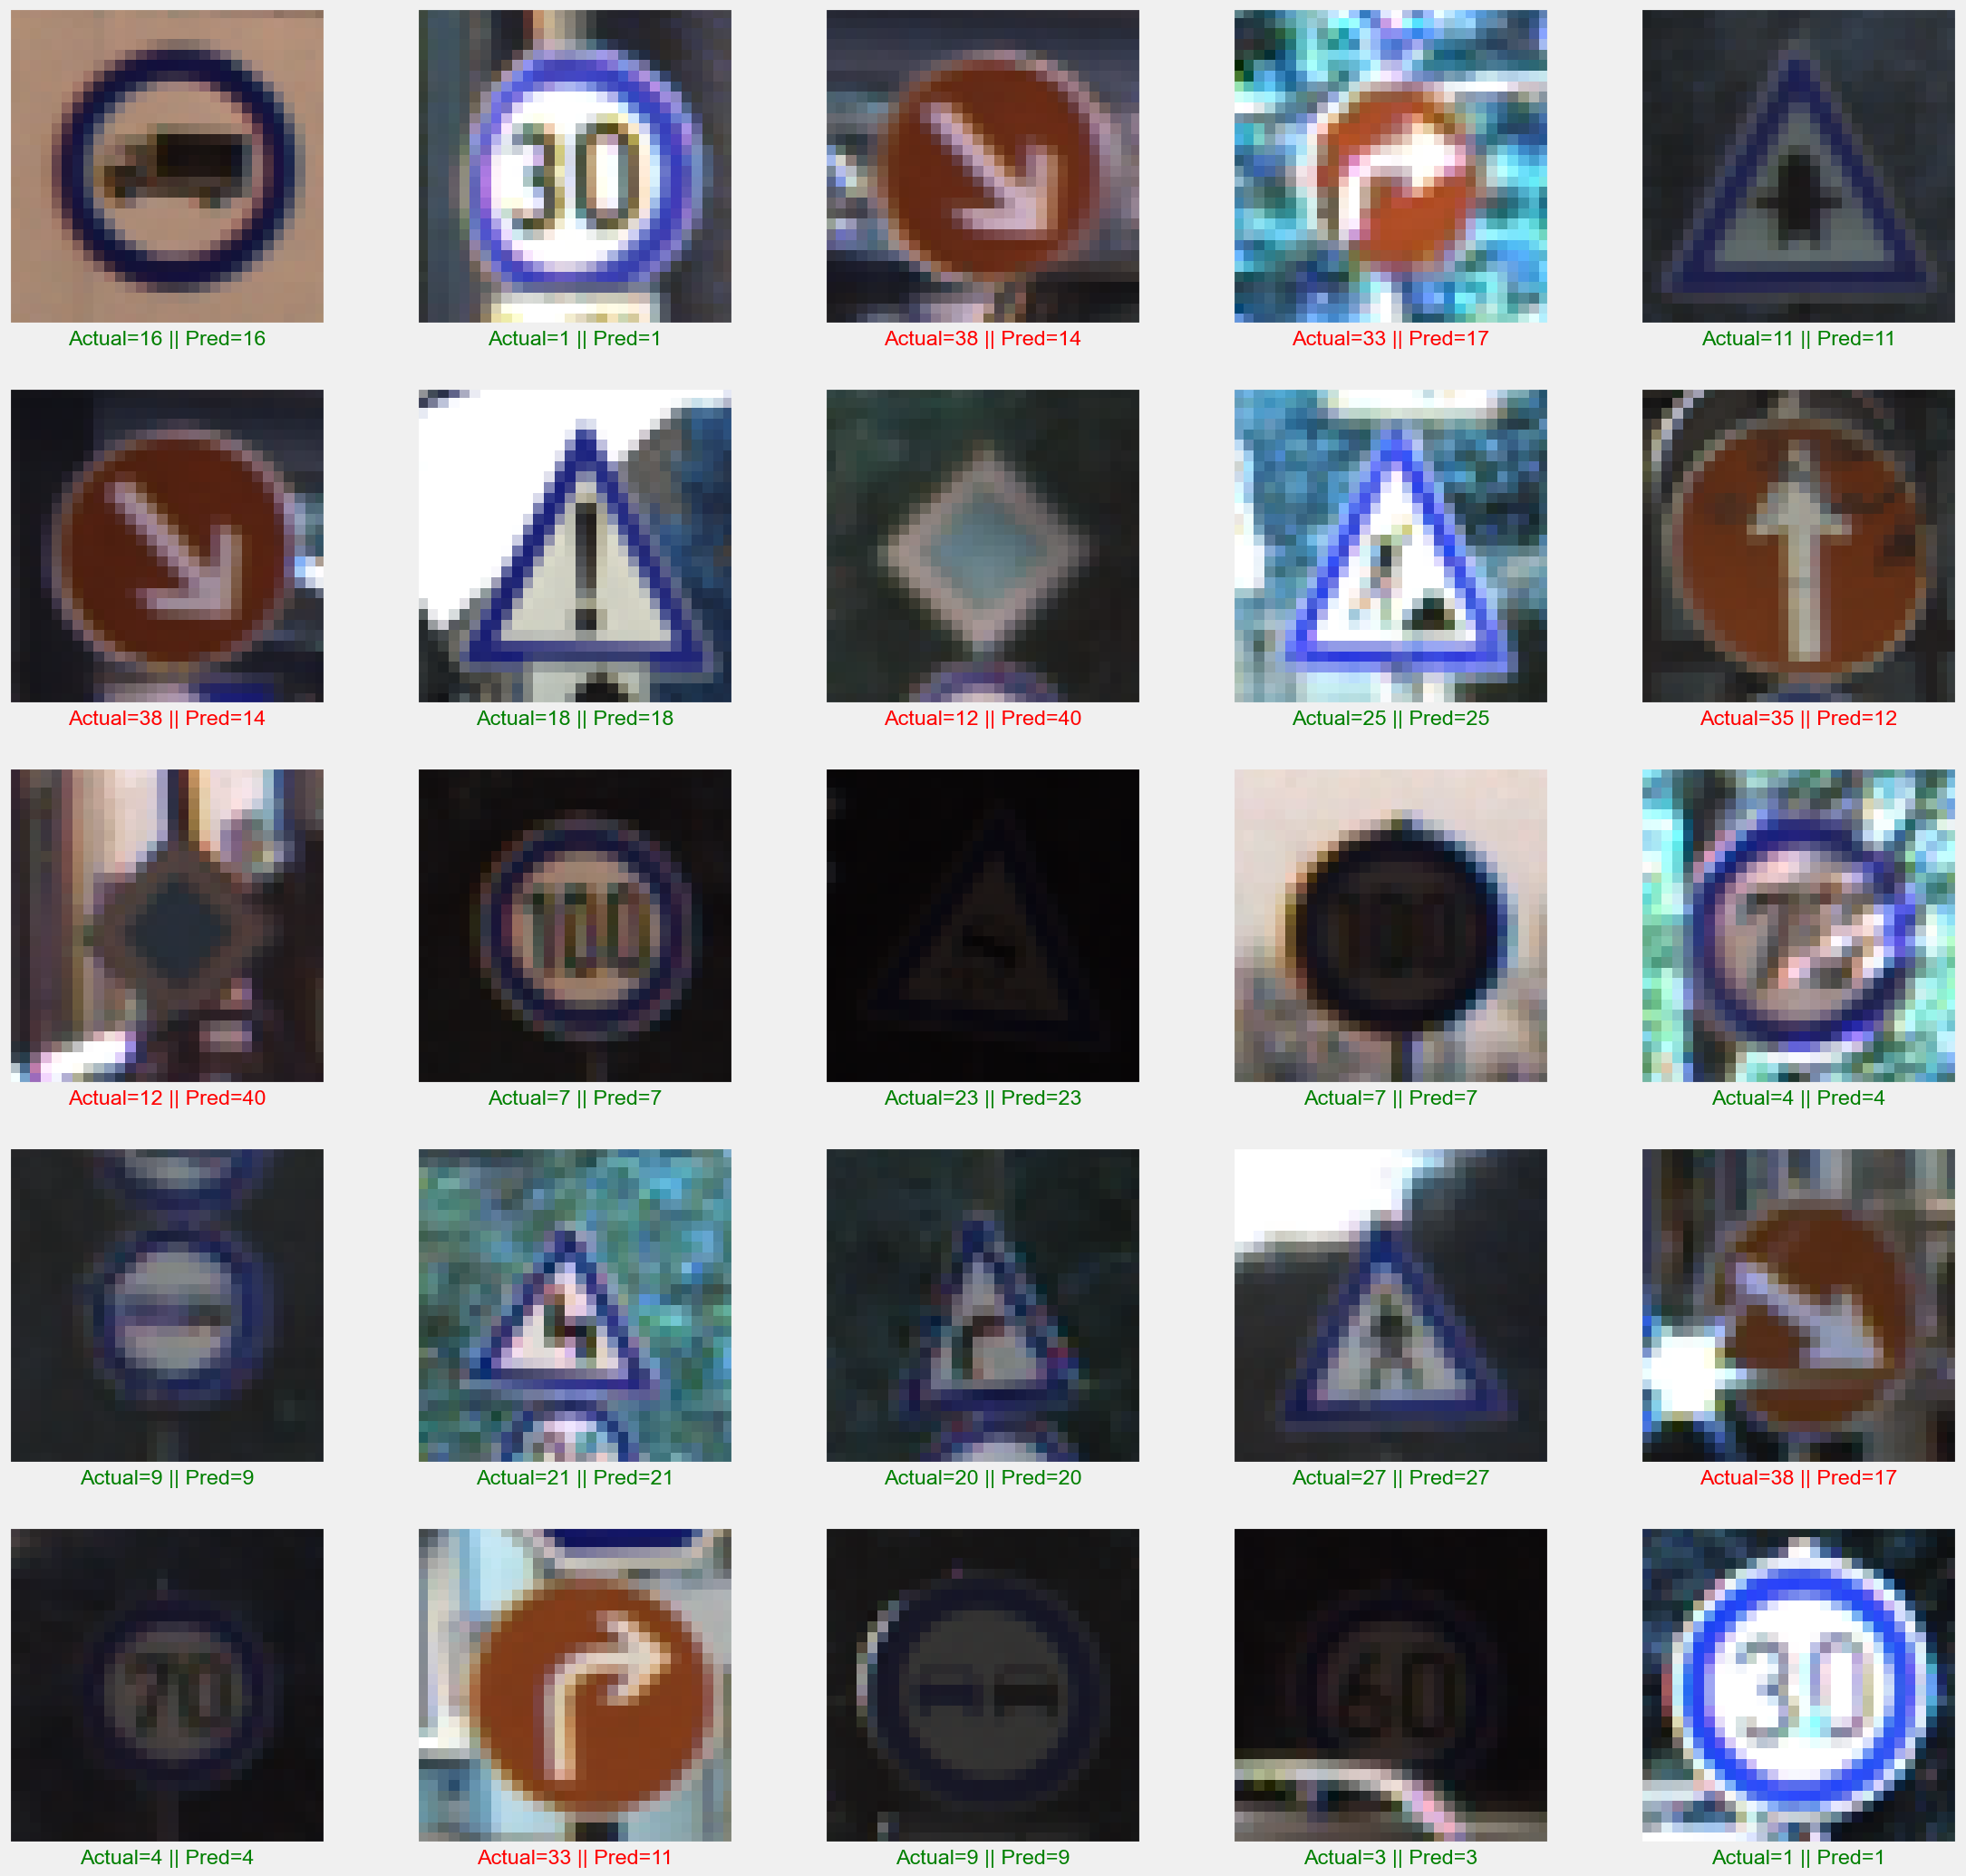

In [83]:
def plot_predictions(images, true_labels, predicted_labels, start_index=0, num_images=25):
    plt.figure(figsize=(25, 25))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        prediction = predicted_labels[start_index + i]
        actual = true_labels[start_index + i]
        col = 'g' if prediction == actual else 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color=col)
        plt.imshow(images[start_index + i])
    plt.show()

# Display predictions for test data
plot_predictions(X_test, labels, pred_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


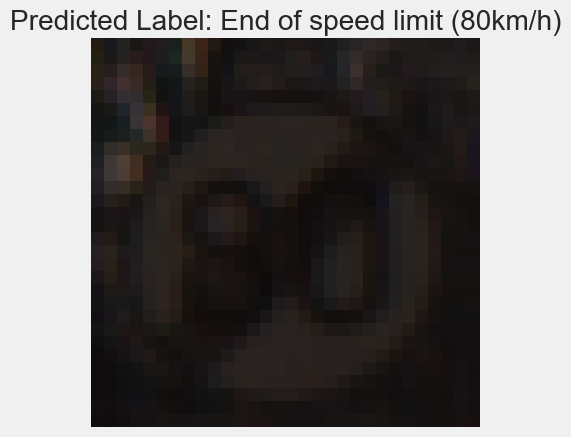

In [84]:
# Read the image
image = cv2.imread("C:\\Users\\cherm\\PycharmProjects\\Traffic-Sign-Recognition-main\\dataset\\Train\\6\\00006_00001_00019.png")

# Resize and preprocess the image
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)
input_data = input_data / 255

# Make prediction
pred = loaded_model.predict(input_data)
result = pred.argmax()
predicted_label = classes[result]

# Display the image
plt.imshow(resize_image)
plt.axis('off')
plt.title(f'Predicted Label: {predicted_label}')
plt.show()